### Import libraries

In [20]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Bigram Language Model

In [21]:
class BigramLanguageModel:
    def __init__(self, titles, smoothing=True, isCollection=False):
        '''
            titles: list of list of titles. Each title should start with <s> and end with </s>
                    e.g. ['<s>', 'Nano', 'water', 'spray', '</s>']
        '''

        self.titles = titles

        self.smoothing = smoothing
        self.isCollection = isCollection

        self.occurrences = {}
        self.total_word_count = 0

        for each_title in self.titles:
            for word_index in range(0, len(each_title)):
                self.total_word_count += 1
                # two_words could be '<s> Nano'
                # or just '</s>' if it is the last word
                try:
                    two_words = (each_title[word_index] + ' ' + each_title[word_index+1]).lower()
                except:
                    two_words = each_title[word_index].lower()
                
                if two_words in self.occurrences:
                    self.occurrences[two_words] += 1
                else:
                    self.occurrences[two_words] = 1

    def calculate_bigram_probability(self, pair_of_words):
        '''
            pair_of_words (STRING): can be a single word or a pair of words separated by a space 
        '''
        try:
            return self.occurrences[pair_of_words]/self.total_word_count
        except:
            if(self.smoothing and self.isCollection):
                return 1/(self.total_word_count + len(self.occurrences))
            return 0
    
    def calculate_sentence_probability(self, sentence, normalize_probability=True):
        '''
            sentence: can be a string separated by spaces or a list of words
        '''
        total_probability = 1

        if(type(sentence) == str):
            processed_sentence = sentence.split()
        else:
            processed_sentence = []
            for word_index in range(0, len(sentence)):
                try:
                    new_word = sentence[word_index] + sentence[word_index+1]
                except:
                    new_word = sentence[word_index]
                processed_sentence.append(new_word)
        
        for each_word in processed_sentence:
            word_prob = self.calculate_bigram_probability(each_word)

            if(normalize_probability):
                total_probability *= np.log2(word_prob)
            else:
                total_probability *= word_prob
            
        return total_probability

### Interpolated sentence probability

In [22]:
def calculate_interpolated_sentence_probability(sentence, doc, collection, alpha=0.75, normalize_probability=True):
    '''
        calculate interpolated sentence/query probability using both sentence and collection unigram models.
        sentence: input sentence/query
        doc: unigram language model a doc. HINT: this can be an instance of the UnigramLanguageModel class
        collection: unigram language model a collection. HINT: this can be an instance of the UnigramLanguageModel class
        alpha: the hyperparameter to combine the two probability scores coming from the document and collection language models.
        normalize_probability: If true then log of probability is not computed. Otherwise take log2 of the probability score.
    '''
    processed_sentence_list = []

    if(type(sentence) == str):
        processed_sentence = "<s> " + sentence + " </s>"
        temp_list = processed_sentence.lower().split()
        for i in range(len(temp_list)):
            try:
                two_words = (temp_list[i] + ' ' +  temp_list[i+1]).lower()
            except:
                two_words = (temp_list[i]).lower()
            processed_sentence_list.append(two_words)
    else:
        temp_list = [each_string.lower() for each_string in sentence]
        temp_list.insert(0, "<s>")
        temp_list.append("</s>")
        for i in range(len(temp_list)):
            try:
                two_words = (temp_list[i] + ' ' + temp_list[i+1]).lower()
            except:
                two_words = (temp_list[i]).lower()
            processed_sentence_list.append(two_words)

    if(temp_list in doc.titles):
        return 1
    
    score = 1
    for each_pair in processed_sentence_list:
        doc_prob = alpha * doc.calculate_bigram_probability(each_pair)
        collection_prob = (1-alpha) * collection.calculate_bigram_probability(each_pair)
        score *= (doc_prob + collection_prob)

    return score

### Function to read CSV

In [23]:
def read_csv_titles(file_name):
    df = pd.read_csv(file_name)
    all_titles = df["title"]
    all_filenames = df["image"]
    
    list_of_titles = all_titles.tolist()
    list_of_filenames = all_filenames.tolist()
    
    processed_titles = []

    # we are only seperating by strings, not accounting for stuff like '/' and '-'
    # so dashes will come up as "words" in this model
    for each_title in list_of_titles:
        each_title = "<s> " + each_title + " </s>"
        processed_titles.append(each_title.lower().split())

    return processed_titles, list_of_filenames

### Setting up Bigram Models

In [24]:
processed_file = "train.csv"

smoothing = True

query = "Paper Bag Victoria Secret"

train_titles, filenames = read_csv_titles(processed_file)
collection_model = BigramLanguageModel(train_titles, smoothing=smoothing, isCollection=True)

In [25]:
def find_matching_document(query, collection_model):
    all_scores = []    
    for doc_index in range(len(train_titles)):
        current_model = BigramLanguageModel([train_titles[doc_index]], smoothing)

        current_score = calculate_interpolated_sentence_probability(query, current_model, collection_model)
        all_scores.append(current_score)

    top_five_indices = sorted(range(len(all_scores)), key=lambda i: all_scores[i])[-5:]
    top_five_scores = sorted(all_scores)[-5:]

    for i in range(0, 5):
        print(f"{i+1}, Index: {top_five_indices[4-i]}, Score: {top_five_scores[4-i]}, Title: {train_titles[top_five_indices[4-i]]}\n")
    
    return top_five_indices

In [28]:
def search_product(query):
    top_five_indices = find_matching_document(query, collection_model)
    top_five_filenames = []

    for i in top_five_indices:
        top_five_filenames.append(filenames[i])

    path_to_images = 'train/train_images/'
    top_five_image_paths = []
    for i in range(len(top_five_filenames)):
        file_abs_path = path_to_images + top_five_filenames[i]
        top_five_image_paths.append(file_abs_path)


    # Read images
    img1 = mpimg.imread(top_five_image_paths[4])
    img2 = mpimg.imread(top_five_image_paths[3])
    img3 = mpimg.imread(top_five_image_paths[2])
    img4 = mpimg.imread(top_five_image_paths[1])
    img5 = mpimg.imread(top_five_image_paths[0])

    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1,ncols=5,figsize=(100,100))

    # show images
    ax1.imshow(img1)
    ax1.set_title("Image 1")
    ax2.imshow(img2)
    ax2.set_title("Image 2")
    ax3.imshow(img3)
    ax3.set_title("Image 3")
    ax4.imshow(img4)
    ax4.set_title("Image 4")
    ax5.imshow(img5)
    ax5.set_title("Image 5")

    plt.show()

### Search for relevant document

1, Index: 11967, Score: 3.8262005978522385e-34, Title: ['<s>', 'lemonilo', 'mie', 'kuah', 'dan', 'goreng', 'instant', 'sehat', 'organic', 'bayam', 'rendah', 'kalori', '</s>']

2, Index: 12130, Score: 8.481858480955581e-40, Title: ['<s>', 'lemonilo', 'mie', 'instant', 'sehat', '70gr', '-', 'mie', 'organik', '/', 'lemonilo', 'mie', '</s>']

3, Index: 18133, Score: 6.439596218292326e-40, Title: ['<s>', 'lemonilo', 'mie', 'instant', 'sehat', '70gr', '-', 'mie', 'organik', '/', 'lemonilo', 'mie', 'instan', '</s>']

4, Index: 26469, Score: 4.24128175504733e-40, Title: ['<s>', 'lemonilo', 'mie', 'instant', 'sehat', '70', 'gr', 'mie', 'organik', '/', 'mie', 'sehat', '</s>']

5, Index: 18686, Score: 4.24128175504733e-40, Title: ['<s>', 'lemonilo', 'mie', 'instant', 'sehat', '70gr', '-', 'mie', 'organik', '/audrey', 'baby', 'shop', '</s>']



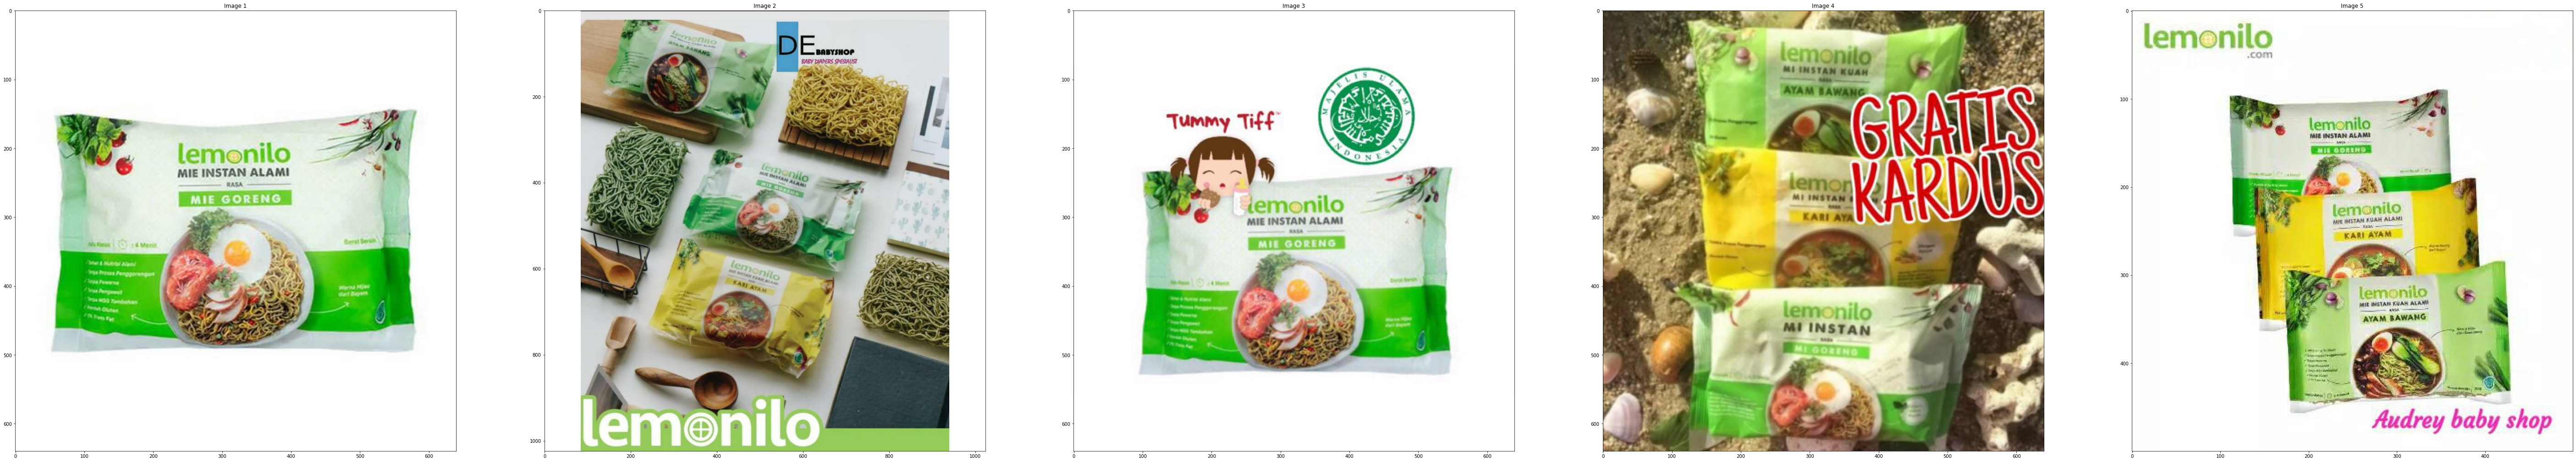

In [29]:
query = "READY Lemonilo Mie instant sehat kuah dan goreng"

search_product(query)

## Map scoring

In [30]:
def MAP_score(gold, predicted):
    '''
        gold (list) - matches in gold.csv
        predicted (list) - list containing posting id of top n documents
        
        e.g. gold = ['train_129225211', 'train_2278313361']
             predicted = ['train_129225211', 'train_1203498230']
    '''
    threshold = len(gold)
    
    recall = []
    precision = []
    
    relevant_indexes = []
    
    num_relevant = 0
    current_count = 0
    
    for i in range(len(predicted)):
        current_count += 1
        if(predicted[i] in gold):
            relevant_indexes.append(i)
            
            num_relevant += 1
            recall.append(num_relevant/threshold)
            precision.append(num_relevant/current_count)
            
        else:
            recall.append(num_relevant/threshold)
            precision.append(num_relevant/current_count)
        
    final_score = 0
    for i in relevant_indexes:
        final_score += precision[i]
    
    if(len(relevant_indexes) != 0):
        final_score /= len(relevant_indexes)
    else:
        return 0
    
    return final_score


def all_MAP_scores(predicted, gold=None):
    '''
        predicted (list of lists): each inner list should consist of all the posting id sorted with [most relevant, ..., least relevant]
    '''
    if(gold==None):
        gold = []
        # read csv and save gold into a list of list
        df = pandas.read_csv('gold.csv')
        matches = df["matches"]

        for i in matches:
            line = re.sub("['\[\]]", '', i)
            gold.append(line.split())
        
    
    total_score = 0
    iterations = 100
    for index in range(iterations):
    #for index in range(len(gold)):
        num_relevant = len(gold[index])
        top_predicted = predicted[index]
        
        total_score += MAP_score(gold[index], top_predicted)
    
    MAP = total_score/iterations #len(gold)
    
    return MAP

In [31]:
def get_all_product_titles():
    df = pd.read_csv('train.csv')
    titles = df["title"]
    posting_id = df["posting_id"]
    
    processed_titles = []
    for each_title in titles:
        processed_titles.append(each_title.lower().split())
    
    return processed_titles, posting_id.tolist()

def get_all_gold():
    gold = []
    # read csv and save gold into a list of list
    df = pd.read_csv('gold.csv')
    matches = df["matches"]

    for i in matches:
        line = re.sub("['\[\]]", '', i)
        gold.append(line.split())
    return gold


In [32]:
def find_matches(query, collection_model, all_document_models, number_relevant, all_posting_ids):
    # for each title in train.csv, we make a model for them
    # interpolated score is then calculated for each title
    # retrieve top 5 scores
    
    all_scores = []
    
    for i in all_document_models:
        current_score = calculate_interpolated_sentence_probability(query, i, collection_model)
        all_scores.append(current_score)
    
    top_n_relevant = sorted(range(len(all_scores)), key=lambda i: all_scores[i])[-number_relevant:]

#     print("Top relevant", top_n_relevant)
#     for i in top_n_relevant:
#         print(all_scores[i], end='')
#     print()
        
    
    top_n_relevant.reverse()
    predicted_posting_id = []
    for i in top_n_relevant:
        predicted_posting_id.append(all_posting_ids[i])
    
#     print("Posting ids:", predicted_posting_id)
    
    return predicted_posting_id

In [ ]:
gold_matches = get_all_gold()
all_titles, all_posting_ids = get_all_product_titles()


# Language models come in here
smoothing = True
collection_model = BigramLanguageModel(all_titles, smoothing, isCollection=True) # train model is our entire corpus
all_document_models = []

for i in range(len(all_titles)):
    current_model = BigramLanguageModel([all_titles[i]], smoothing)
    all_document_models.append(current_model)


# For each product, we generate query and get top N predicted
all_predicted = []
for each_product_index in range(len(gold_matches)):
    if(each_product_index == 100):
        break
    if(each_product_index != 0):
        if(each_product_index % 100 == 0):
            print(each_product_index)
    number_relevant = len(gold_matches[each_product_index])
    
    current_predicted_posting_ids = find_matches(all_titles[each_product_index], collection_model, all_document_models, number_relevant, all_posting_ids)
    all_predicted.append(current_predicted_posting_ids)

to_save = pd.DataFrame(all_predicted)
to_save.to_csv("Bigram_results.csv")

final_MAP_score = all_MAP_scores(all_predicted, gold_matches)